In [15]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('-wp' , '--wandb_project', help='Project name used to track experiments in Weights & Biases dashboard' , type=str, default='myprojectname')
parser.add_argument('-we', '--wandb_entity' , help='Wandb Entity used to track experiments in the Weights & Biases dashboard.' , type=str, default='myname')
parser.add_argument('-d', '--dataset', help='choices: ["mnist", "fashion_mnist"]', type=str, default='fashion_mnist')
parser.add_argument('-e', '--epochs', help="Number of epochs to train neural network.", type=int, default=1)
parser.add_argument('-b', '--batch_size', help="Batch size used to train neural network.", type=int, default=4)
parser.add_argument('-l','--loss', help = 'hoices: ["mean_squared_error", "cross_entropy"]' , type=str, default='cross_entropy')
parser.add_argument('-o', '--optimizer', help = 'choices: ["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]', type=str, default = 'sgd', required=True)
parser.add_argument('-lr', '--learning_rate', help = 'Learning rate used to optimize model parameters', type=float, default=0.1)
parser.add_argument('-m', '--momentum', help='Momentum used by momentum and nag optimizers.',type=float, default=0.5)
parser.add_argument('-beta', '--beta', help='Beta used by rmsprop optimizer',type=float, default=0.5)
parser.add_argument('-beta1', '--beta1', help='Beta1 used by adam and nadam optimizers.',type=float, default=0.5)
parser.add_argument('-beta2', '--beta2', help='Beta2 used by adam and nadam optimizers.',type=float, default=0.5)
parser.add_argument('-eps', '--epsilon', help='Epsilon used by optimizers.',type=float, default=0.000001)
parser.add_argument('-w_d', '--weight_decay', help='Weight decay used by optimizers.',type=float, default=.0)
parser.add_argument('-w_i', '--weight_init', help = 'choices: ["random", "Xavier"]', type=str, default='random')
parser.add_argument('-nhl', '--num_layers', help='Number of hidden layers used in feedforward neural network.',type=int, default=1)
parser.add_argument('-sz', '--hidden_size', help ='Number of hidden neurons in a feedforward layer.', nargs='+', type=int, default=4, required=False)
parser.add_argument('-a', '--activation', help='choices: ["identity", "sigmoid", "tanh", "ReLU"]', type=str, default='sigmoid')


_StoreAction(option_strings=['-a', '--activation'], dest='activation', nargs=None, const=None, default='sigmoid', type=<class 'str'>, choices=None, required=False, help='choices: ["identity", "sigmoid", "tanh", "ReLU"]', metavar=None)

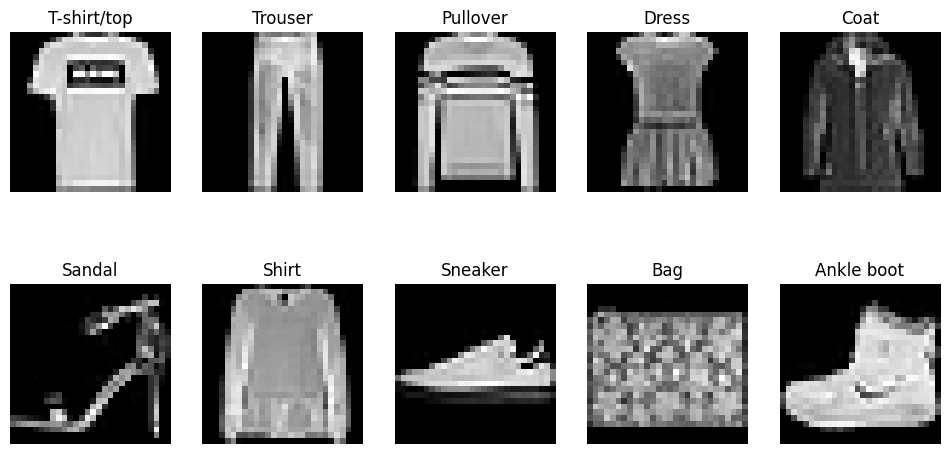

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(train_image,train_label),(test_image,test_label)=fashion_mnist.load_data()
# Define the class names
class_type=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker', 'Bag','Ankle boot']

# Plot one sample image for each class
fig,axs=plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(len(class_type)):
    row=i//5
    col=i%5
    class_idx = np.where(train_label == i)[0][0]
    axs[row, col].imshow(train_image[class_idx], cmap='gray')
    axs[row, col].set_title(class_type[i])
    axs[row, col].axis('off')
plt.show()
train_image = train_image.reshape(train_image.shape[0], train_image.shape[1]*train_image.shape[2])
train_label = train_label.reshape(train_label.shape[0],1)


In [30]:
class FNN():
    def __init__(self, size_of_each_layer, no_of_layer, epochs=10, L_rate=0.001, optm='sgd', batch_size=16, act_f='sigmoid', loss_f='cross_entropy', output_act_f='softmax', initializer='xavier'):
        self.size_of_each_layer = size_of_each_layer			
        self.no_of_layer = no_of_layer
        self.epochs = epochs
        self.L_rate = L_rate
        self.optm = optm                #Optimizer
        self.batch_size = batch_size
        self.act_f = act_f
        self.initializer = initializer		#Weight inititialisation
        self.loss_f = loss_f	
        self.output_act_f = output_act_f	
        self.parameters = self.parameter_initialisation()	#Weights and biases initialisation.
        
    def activation_function(self, x,output_layer=0, return_derivative=0):
        #IF OUTPUT LAYER =>
        if output_layer:
            exps = np.exp(x - x.max())
            if return_derivative:
                return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
            return exps / np.sum(exps, axis=0)
        #IF NOT OUTPUT LAYER GO BELOW =>    
        if self.act_f == 'sigmoid':
            if return_derivative:
                return (np.exp(-x))/((np.exp(-x)+1)**2)
            else:
                return 1/(1 + np.exp(-x))
        elif self.act_f == 'tanh':
            result= (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
            if return_derivative:
                return 1 - (result)**2
            else:
                return result
        elif self.act_f == 'relu':
            if return_derivative:
                return 1. * (x > 0)
            return x * (x > 0)
    def parameter_initialisation(self):
        parameters = {}
        for level in range(1, self.no_of_layer):
            if self.initializer == 'random':
                parameters["W" + str(level)] = np.random.randn(self.size_of_each_layer[level], self.size_of_each_layer[level - 1])*0.1
            elif self.initializer == 'xavier':
                parameters["W" + str(level)] = np.random.randn(self.size_of_each_layer[level], self.size_of_each_layer[level - 1]) * np.sqrt(2/ (self.size_of_each_layer[level - 1] + self.size_of_each_layer[level]))
            parameters["b" + str(level)] = np.zeros((self.size_of_each_layer[level], 1))
        return parameters
    def grad_initialisation(self):
        grad={}
        for level in range(1, self.no_of_layer):
            grad["W" + str(level)] = np.zeros((self.size_of_each_layer[level], self.size_of_each_layer[level - 1]))
            grad["b" + str(level)] = np.zeros((self.size_of_each_layer[level], 1))
        return grad
    # Forward Propagation
    def Forward_Prop(self, x):
        pre_actn_values = {}
        post_actn_values = {}

        post_actn_values['h0'] = x.reshape(len(x),1)

        # From layer 1 to last_layer-1
        for level in range(1, self.no_of_layer-1):
            pre_actn_values['a' + str(level)] = self.parameters['b' + str(level)] + np.matmul(self.parameters['W' + str(level)], post_actn_values['h' + str(level-1)])
            post_actn_values['h' + str(level)] = self.activation_function(pre_actn_values['a' + str(level)],output_layer=0, return_derivative=0)

        # Last layer
        pre_actn_values['a' + str(self.no_of_layer-1)] = self.parameters['b' + str(self.no_of_layer-1)] + + np.matmul(self.parameters['W' + str(self.no_of_layer-1)], post_actn_values['h' + str(self.no_of_layer-1-1)])
        post_actn_values['h' + str(self.no_of_layer-1)] = self.activation_function(pre_actn_values['a' + str(self.no_of_layer-1)],output_layer=1,return_derivative=0)

        return post_actn_values, pre_actn_values
    
    # Back Propogation
    def backwardPropagation(self, y, post_actn_values, pre_actn_values):
        grad={}

        # Compute output gradient
        f_x=post_actn_values['h' + str(self.no_of_layer-1)]
        e_y = y.reshape(len(y), 1)
        
        # Gradient with respect to last layer
        if self.loss_f == 'cross_entropy':
            grad['a' + str(self.no_of_layer-1)] = (f_x - e_y)
        elif self.loss_f == 'squared_error':
            grad['a' + str(self.no_of_layer-1)] = (f_x - e_y)*f_x*(1-f_x)

        # Compute gradients for hidden layers
        for level in range(self.no_of_layer-1, 0, -1):
            # Compute gradients with respect to paramters
            grad['W' + str(level)] = np.outer(grad['a' + str(level)], post_actn_values['h' + str(level-1)])
            grad['b' + str(level)] = grad['a' + str(level)]

            # Compute gradient with respect to layer below
            grad['h' + str(level-1)] = np.dot(self.parameters['W' + str(level)].T, grad['a' + str(level)])

            # Compute gradient with respect to layer below (pre-activation)
            if level > 1:
                grad['a' + str(level-1)] = grad['h' + str(level-1)] * self.activation_function(pre_actn_values['a' + str(level-1)], return_derivative=1)	

        return grad
    

In [31]:
fnn_instance=FNN(size_of_each_layer=[784,256, 128, 32, 10], no_of_layer=5)
x = fnn_instance.Forward_Prop(train_image[0])


(784, 1)
(256, 1)
